# Import Libraries

In [192]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import pacf
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from typing import List
from glob import glob
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Data Loading

In [193]:
datasets_paths = glob("../data/*.csv")
datasets: List[pd.DataFrame] = [pd.read_csv(path) for path in datasets_paths]

# Data Preparation

- Treat the records with `anomaly = True` from the dataset, and then impute them.
- Remove the `anomaly` column from the dataset.

In [194]:
for i, dataset in enumerate(datasets):
    if "anomaly" in dataset.columns:
        # Replace anomalies with 'NaN'
        dataset.loc[dataset.anomaly == 1, "value"] = np.nan

        # Remove the 'anomaly' column
        dataset = dataset.drop(columns=["anomaly"])

        # Update the dataset
        datasets[i] = dataset

- Convert the timestamp column to the `datetime` datatype
- Set the timestamp column as the index of the dataframe

In [195]:
for i, dataset in enumerate(datasets):
    # Convert the 'timestamp' column to datetime
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

    # Set the 'timestamp' column as the index
    dataset = dataset.set_index("timestamp")

    # Update the dataset
    datasets[i] = dataset

- Remove Outliers

In [196]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def __zscore(self, X):
        X = np.nan_to_num(X, copy=True, nan=0)  # Convert the NaN values to 0
        return (X - np.mean(X)) / np.std(X)

    def transform(self, X: pd.DataFrame, y=None):
        """
        Calculate the z-score for each column in the DataFrame and remove the rows with z-score > threshold
        """

        X_copy = X.copy().to_numpy()
        column = X_copy[:, 0]
        z_scores = self.__zscore(column)
        outliers = np.abs(z_scores) > self.threshold
        X_copy[outliers] = np.nan

        return pd.DataFrame(X_copy, columns=X.columns, index=X.index)

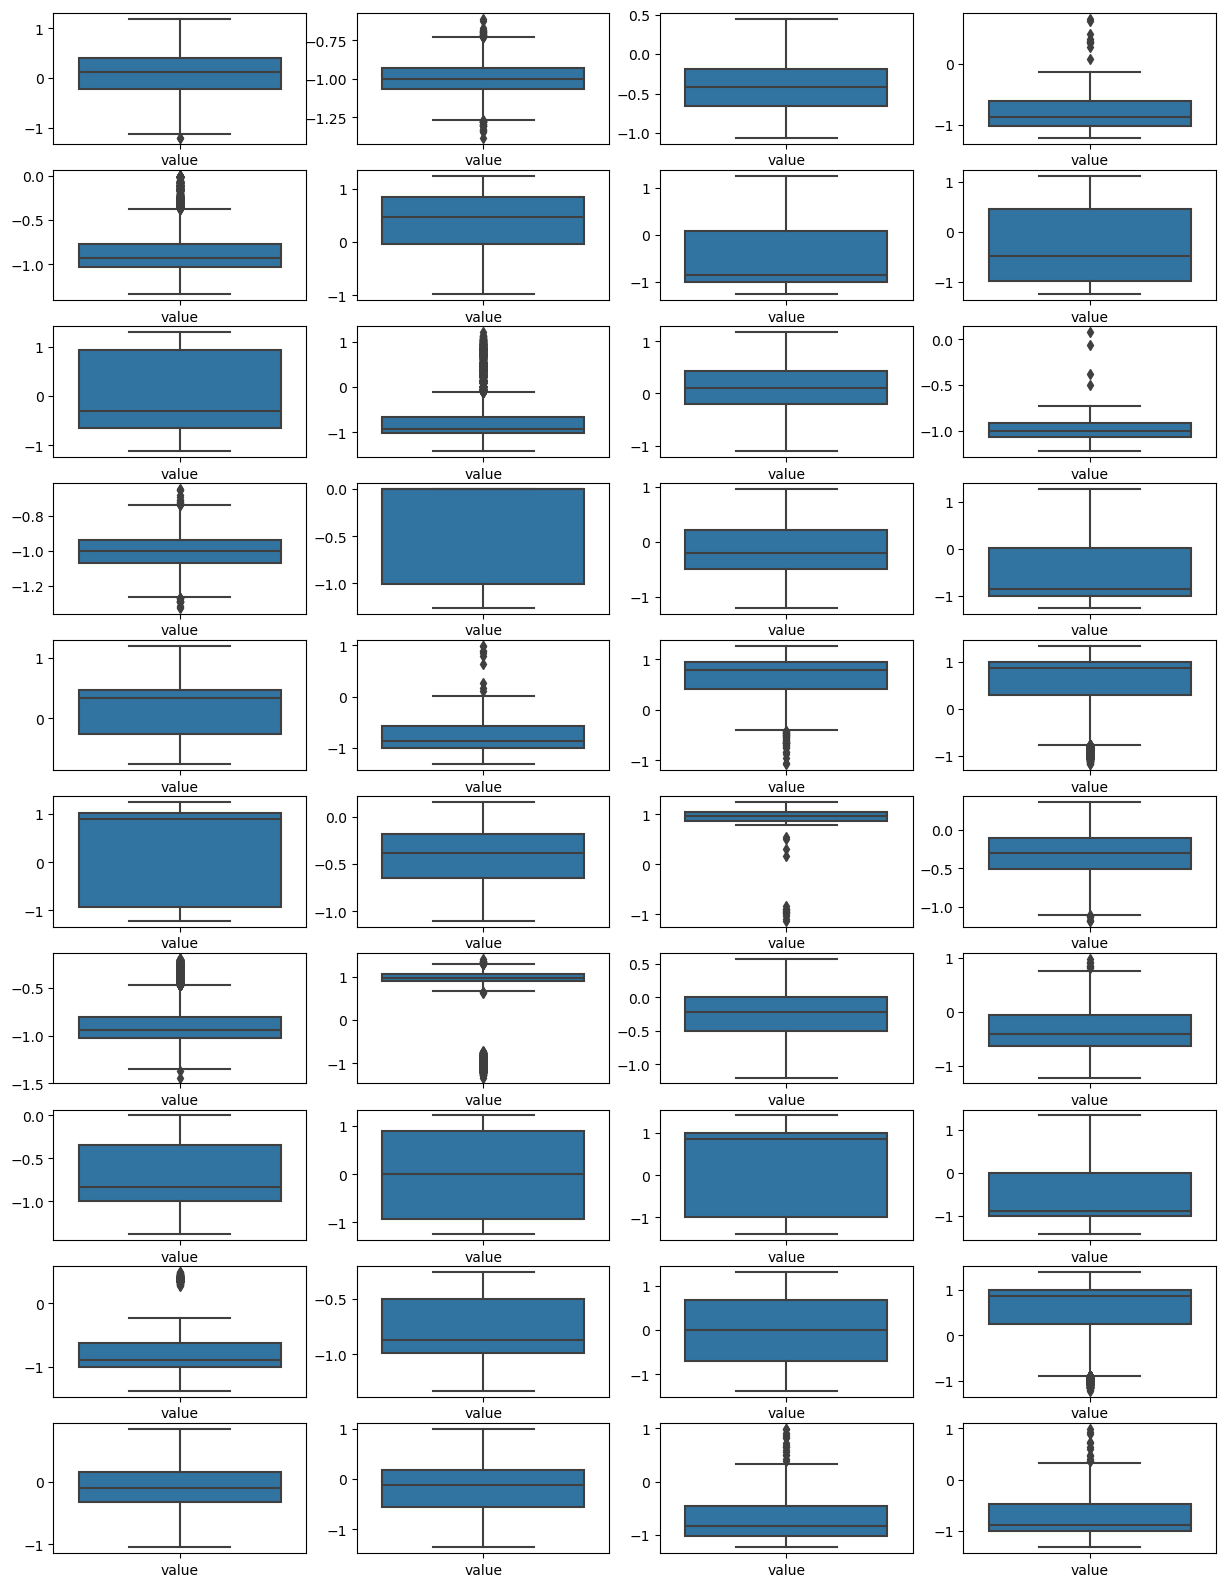

In [197]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

In [198]:
# datasets with no outliers
datasets = [
    OutlierTransformer(threshold=2).fit_transform(dataset) for dataset in datasets
]

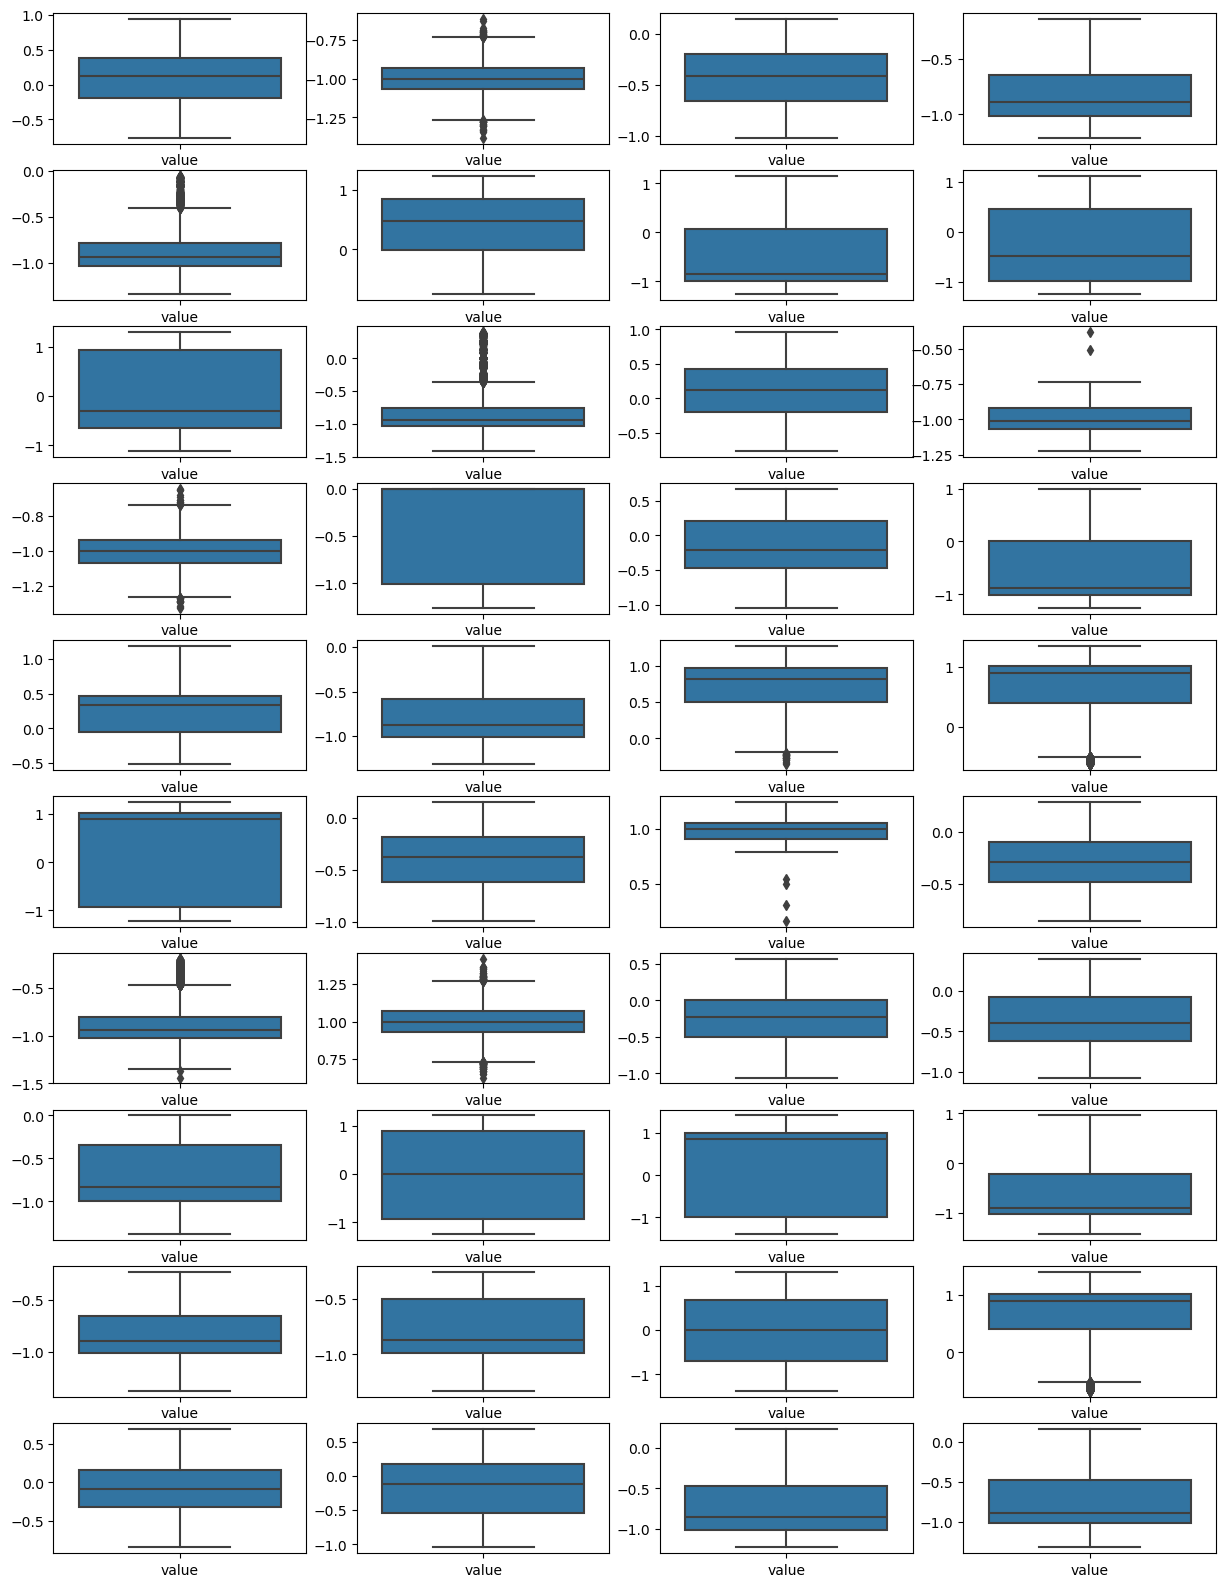

In [199]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

# Data Preprocessing Pipeline

## Data Cleaning

- Impute missing values using `Interpolation`

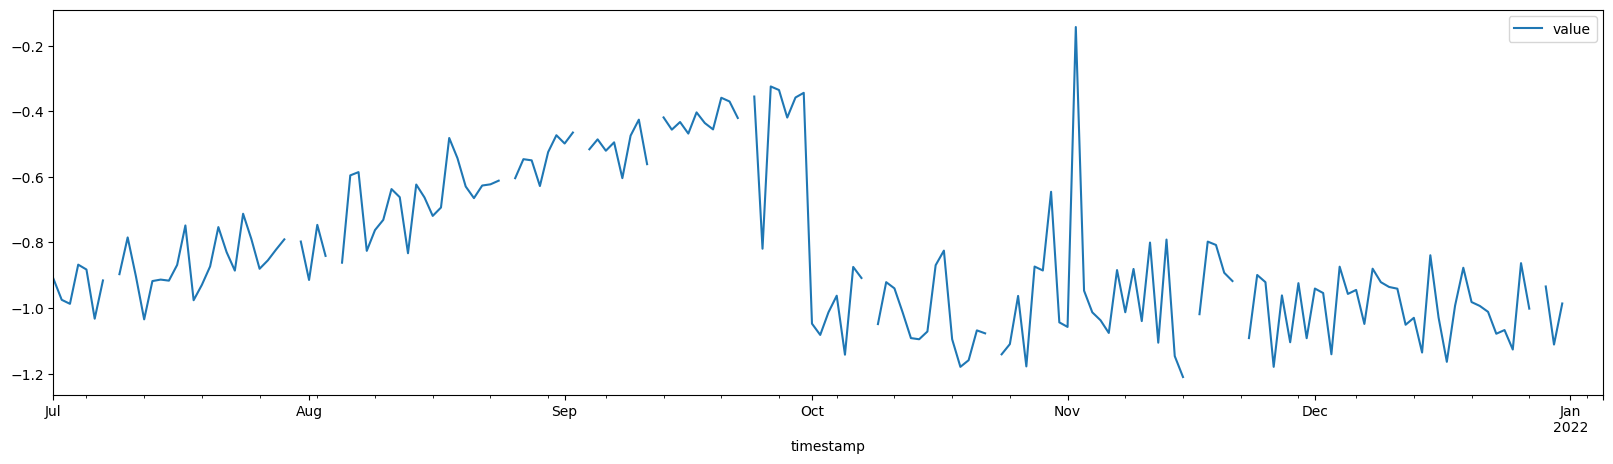

In [200]:
sample_dataset = datasets[3].copy()

sample_dataset.plot(figsize=(20, 5))
plt.show()

In [201]:
class InterpolationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method="linear", order=None):
        self.method = method
        self.order = order

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy.interpolate(method=self.method, order=self.order, inplace=True)

        return X_copy

In [202]:
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter = interpolation_transformer.fit_transform(sample_dataset)

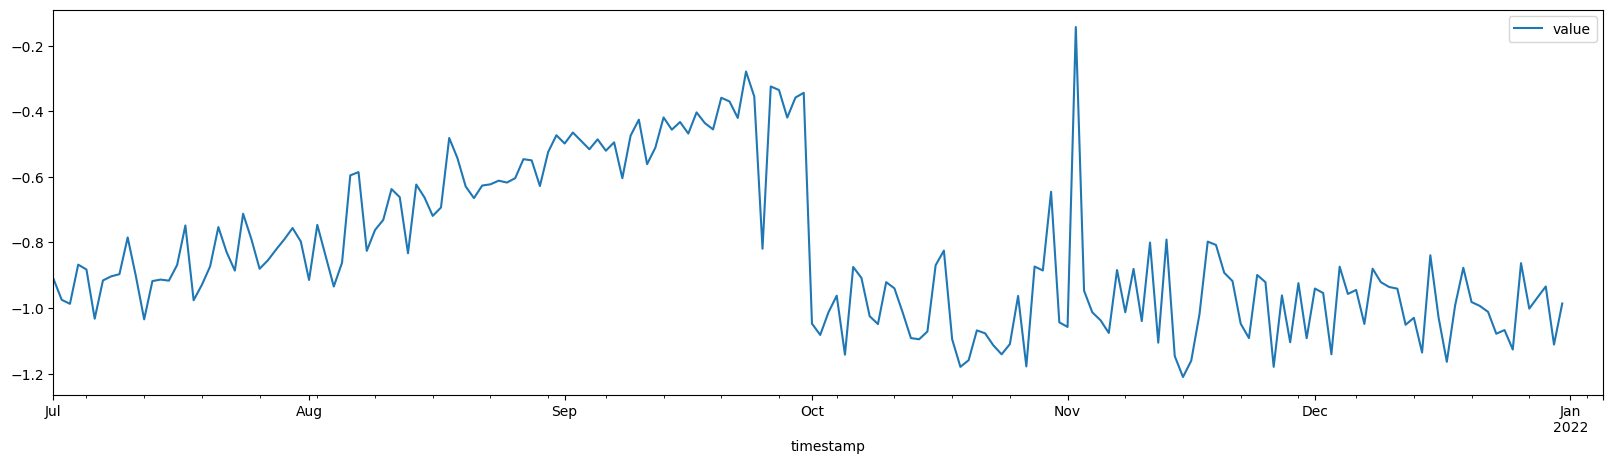

In [203]:
sample_dataset_inter.plot(figsize=(20, 5))
plt.show()

## Feature Engineering

### Seasonality

Adding Seasonality features to the dataset based on its frequencies.

In [ ]:
class SeasonalityFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top=5):
        self.top = top
        self.top_freq: None

    def fit(self, X: pd.DataFrame, y=None):
        if X.isna().sum().value > 0:
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        # Copy the value column from the dataset
        X_copy = X.copy().value

        fft_result = np.fft.fft(X_copy)
        # Calculate only positive power spectral density and frequencies
        # Exclude the first value (0 Hz)
        psd = (np.abs(fft_result) ** 2)[: len(X_copy) // 2][1:]
        freq = np.fft.fftfreq(len(X_copy), 1)[: len(X_copy) // 2][1:]

        # Pick the top frequencies
        top_freq_indices = np.argsort(psd, axis=0)[::-1][: self.top]
        self.top_freq = freq[top_freq_indices]

        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        if X.isna().sum().value > 0:
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        X_copy = X.copy().index.values.astype(float)

        # Calculate the seasonality features
        seasonality_features = pd.DataFrame(
            index=X.index,
            columns=[f"seasonality_sin_{i}" for i in range(self.top)]
            + [f"seasonality_cos_{i}" for i in range(self.top)],
            dtype=float,
        )
        for i, freq in enumerate(self.top_freq):
            seasonality_features.loc[:, f"seasonality_sin_{i}"] = np.sin(
                2 * np.pi * freq * X_copy
            )
            seasonality_features.loc[:, f"seasonality_cos_{i}"] = np.cos(
                2 * np.pi * freq * X_copy
            )

        # Add the seasonality features to the dataset
        return pd.concat([X, seasonality_features], axis=1)

In [205]:
sample_dataset = datasets[7].copy()

In [206]:
# Impute the NaN values from the dataset (interpolation) before Seasonality Features
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter = interpolation_transformer.fit_transform(sample_dataset)

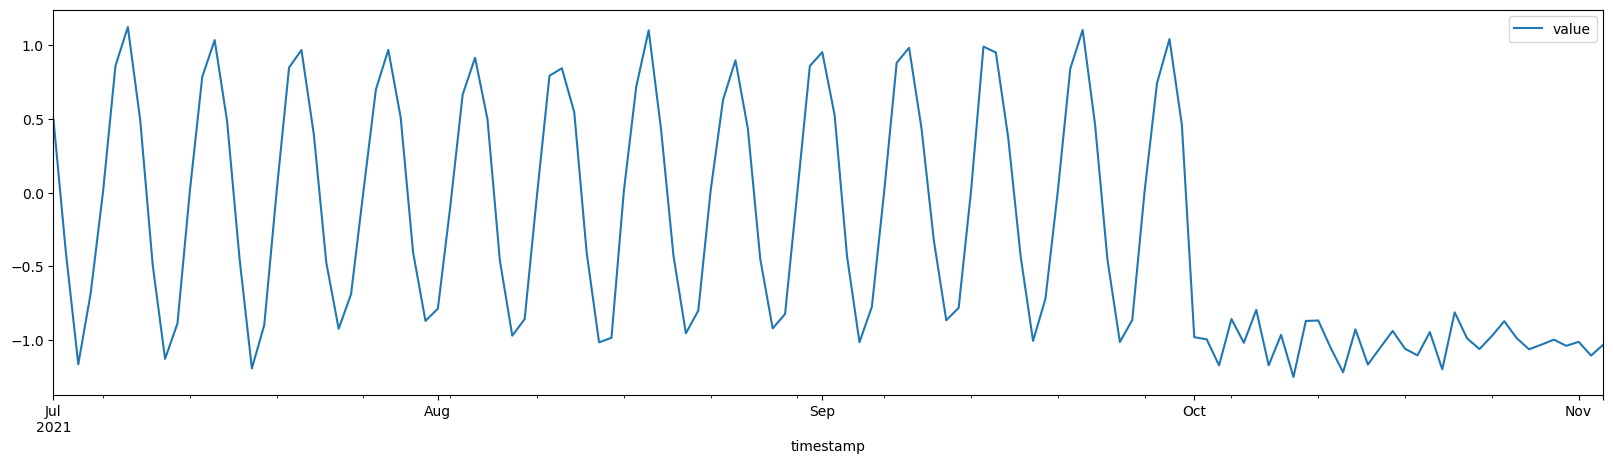

In [207]:
sample_dataset_inter.plot(figsize=(20, 5))
plt.show()

In [208]:
seasonality_transformer = SeasonalityFeaturesTransformer(top=1)
seasonality_transformer.fit(sample_dataset_inter)

SeasonalityFeaturesTransformer(top=1)

In [209]:
seasonality_transformer.top_freq

array([0.14285714])

In [210]:
sample_dataset_seasonality = seasonality_transformer.transform(sample_dataset_inter)

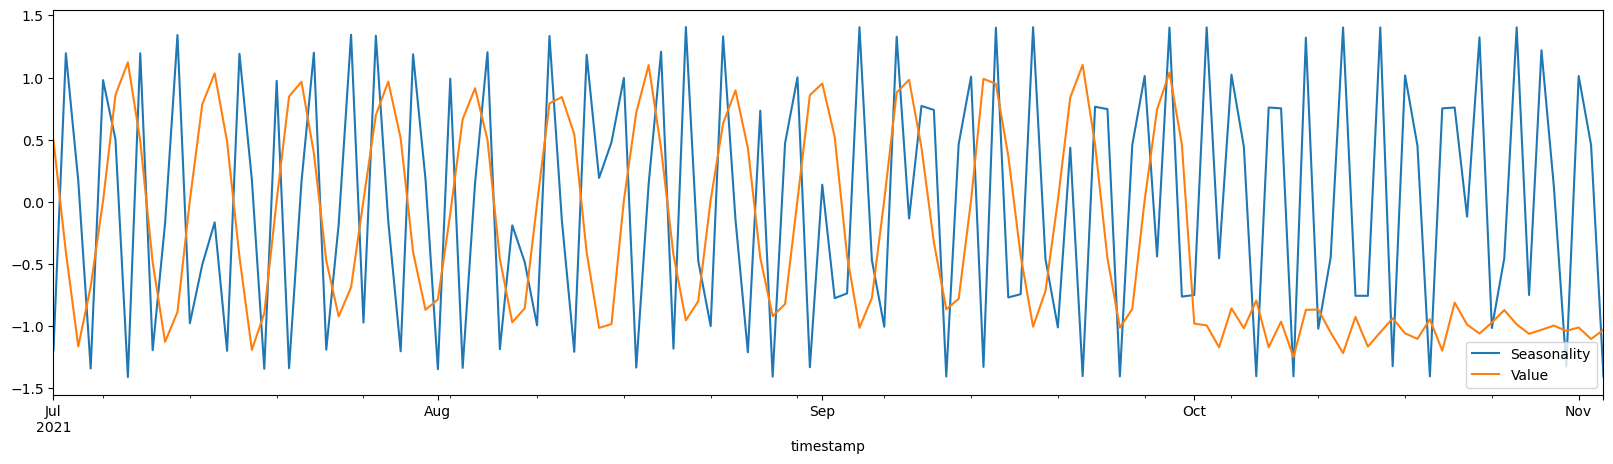

In [211]:
(
    sample_dataset_seasonality["seasonality_cos_0"]
    + sample_dataset_seasonality["seasonality_sin_0"]
).plot(figsize=(20, 5))
sample_dataset_seasonality["value"].plot(figsize=(20, 5))
plt.legend(["Seasonality", "Value"])
plt.show()

### Trend

In [212]:
# Create Trend Transformer class
class TrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=10, degree=3):
        self.window_size = window_size
        self.degree = degree
        self.lr = LinearRegression()
        self.poly = PolynomialFeatures(degree=self.degree)

    def fit(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()

        values = X_copy["value"]
        timestamps = X_copy.index.values.reshape(-1, 1).astype(float)

        # Calculate the trend using the window average
        expanding_mean = values.expanding(self.window_size).mean().bfill().to_numpy()

        # Create the features for the linear regression
        features = self.poly.fit_transform(timestamps)

        # Fit the linear regression
        self.lr.fit(features, expanding_mean.reshape(-1, 1))

        return self

    def transform(self, X: np.ndarray, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        timestamps = X_copy.index.values.reshape(-1, 1).astype(float)

        features = self.poly.fit_transform(timestamps)
        trend = self.lr.predict(features)

        return pd.concat(
            [X, pd.DataFrame(data=trend, index=X.index, columns=["trend"])], axis=1
        )

In [213]:
trend_transformer = TrendTransformer(window_size=1, degree=3)

trend_transformer.fit(sample_dataset_seasonality)

TrendTransformer(window_size=1)

In [214]:
sample_dataset_trend = trend_transformer.transform(sample_dataset_seasonality)

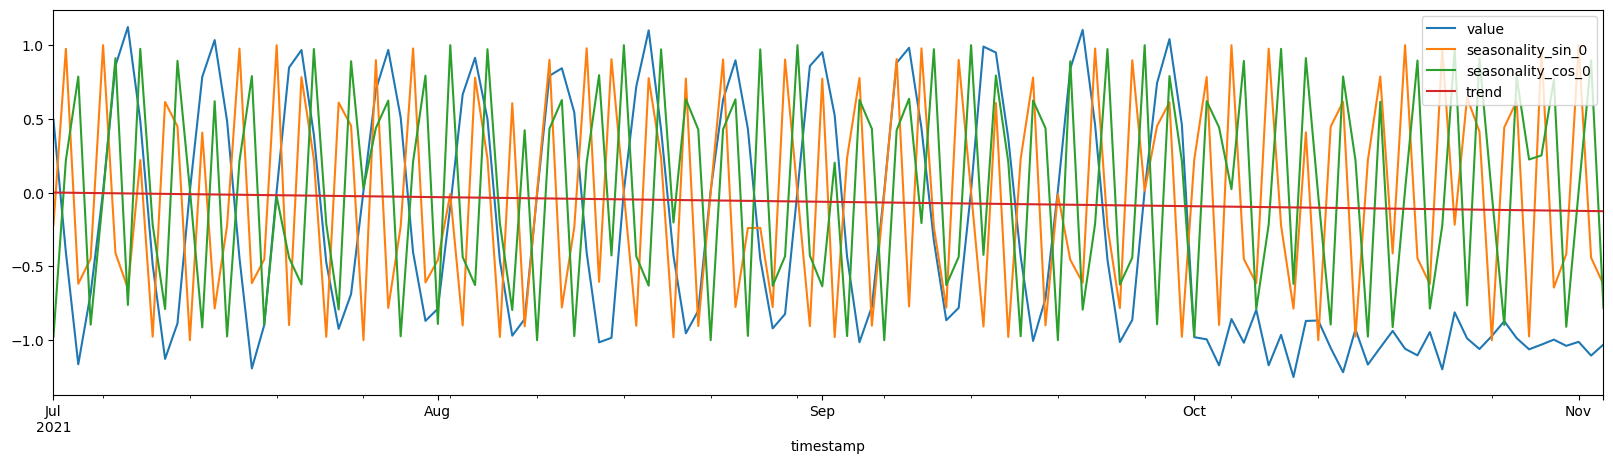

In [215]:
sample_dataset_trend.plot(figsize=(20, 5))
plt.show()

### Lagged Features

Choosing the lagged features that are highly correlated with the target variable. 

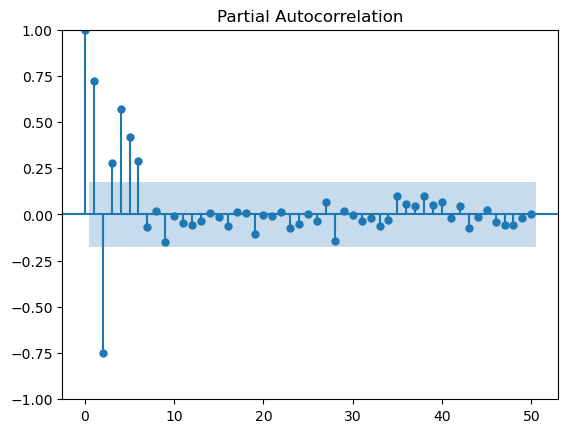

In [216]:
plot_pacf(sample_dataset_trend["value"], lags=50)
plt.show()

In [221]:
class AutocorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_n_lags=3):
        if 10 < max_n_lags < 1:
            raise ValueError("max_lags should be between 1 and 10")

        self.significant_lags = None
        self.max_n_lags = max_n_lags
        self.max_lag = None

    def fit(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()
        value = X_copy["value"]

        # Calculate the PACF values
        pacf_values = pacf(
            value,
            nlags=10,
        )

        # Sort the PACF values
        top_pacf_values = list(
            filter(
                lambda pacf_value: abs(pacf_value) > 2 / len(value) ** 0.5, pacf_values
            )
        )

        # Pick the top lags
        significant_lags = np.argsort(abs(np.array(top_pacf_values)))[::-1]
        self.significant_lags = significant_lags[1 : self.max_n_lags + 1]

        # Calculate the max lag
        self.max_lag = max(self.significant_lags)

        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        value = X_copy["value"]

        # Excluding the first lag (autocorrelation = 1) and Lag 0 (constant)
        correlation_features = pd.DataFrame(
            index=X_copy.index,
            columns=[f"lag_{i}" for i in range(1, self.max_lag)],
        )

        for i, lag in enumerate(self.significant_lags):
            correlation_features.loc[:, f"lag_{i}"] = value.shift(lag)

        # Backfill the NaN values
        correlation_features = correlation_features.bfill()

        return pd.concat([X, correlation_features], axis=1)

In [222]:
autocorrelation_transformer = AutocorrelationTransformer(max_n_lags=2)
autocorrelation_transformer.fit(sample_dataset_trend)

AutocorrelationTransformer(max_n_lags=2)

In [223]:
sample_dataset_lagged = autocorrelation_transformer.transform(sample_dataset_trend)

<Axes: xlabel='timestamp'>

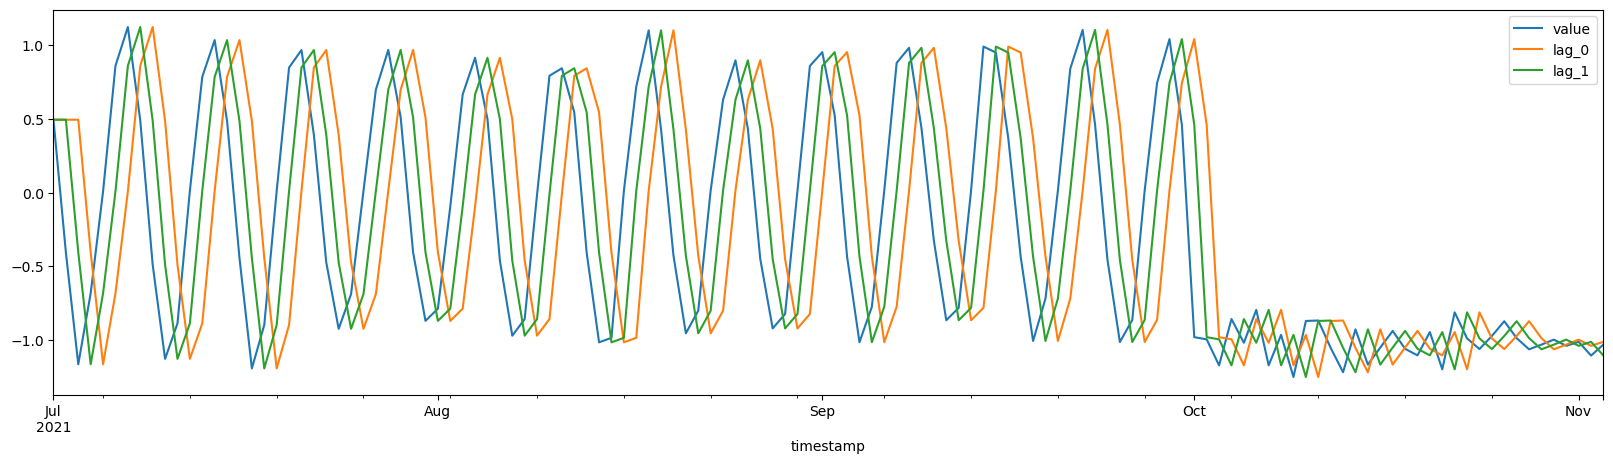

In [224]:
sample_dataset_lagged[
    ["value"] + [f"lag_{i}" for i in range(autocorrelation_transformer.max_lag)]
].plot(figsize=(20, 5))

## Create pipeline

In [225]:
cleaning_pipeline = Pipeline(
    [
        ("outlier", OutlierTransformer()),
    ]
)

In [226]:
preprocessing_pipeline = Pipeline(
    [
        ("interpolation", InterpolationTransformer()),
        ("seasonality", SeasonalityFeaturesTransformer()),
        ("trend", TrendTransformer()),
        ("autocorrelation", AutocorrelationTransformer()),
    ]
)

In [227]:
test_dataset = datasets[0].copy()

In [228]:
preprocessing_pipeline.fit(test_dataset)

Pipeline(steps=[('interpolation', InterpolationTransformer()),
                ('seasonality', SeasonalityFeaturesTransformer()),
                ('trend', TrendTransformer()),
                ('autocorrelation', AutocorrelationTransformer())])

In [229]:
test_dataset_pre = preprocessing_pipeline.transform(test_dataset)

In [230]:
test_dataset_pre.head(20)

,value,seasonality_sin_0,seasonality_sin_1,seasonality_sin_2,seasonality_sin_3,seasonality_sin_4,seasonality_cos_0,seasonality_cos_1,seasonality_cos_2,seasonality_cos_3,seasonality_cos_4,trend,lag_1,lag_2,lag_0
timestamp,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.416510,0.97971,-0.998509,-0.269332,-0.518759,-0.74496,-0.200422,-0.054585,0.963047,0.85492,-0.667109,0.207544,0.416510,0.416510,0.416510
2021-07-01 01:00:00,0.476706,0.729035,0.116437,0.452375,-0.806881,0.956055,0.684476,0.993198,-0.891828,0.590715,-0.293188,0.207522,0.416510,0.416510,0.416510
2021-07-01 02:00:00,0.536902,0.856981,0.95881,-0.617966,-0.971695,-0.2429,0.515347,-0.28405,0.786205,0.236237,0.970051,0.207501,0.416510,0.416510,0.476706
2021-07-01 03:00:00,0.622415,0.946385,-0.443347,0.354967,-0.663702,-0.705074,0.32304,-0.89635,-0.934879,0.747997,-0.709134,0.207479,0.476706,0.416510,0.536902
2021-07-01 04:00:00,0.707928,0.282291,0.700902,-0.530852,-0.899756,0.97143,0.959329,0.713258,0.847465,0.436393,-0.237326,0.207457,0.536902,0.476706,0.622415
2021-07-01 05:00:00,0.668175,0.478244,0.58333,0.686258,-0.998311,-0.298673,0.878227,-0.812236,-0.727358,0.0581,0.954356,0.207436,0.622415,0.536902,0.707928
2021-07-01 06:00:00,0.691913,0.652688,-0.89979,-0.815191,-0.944305,-0.948626,0.757627,-0.436323,0.579193,-0.329071,0.316399,0.207414,0.707928,0.622415,0.668175
2021-07-01 07:00:00,0.777380,0.797777,-0.276543,0.912676,-0.745992,0.21919,0.602953,0.961002,-0.408684,-0.665955,-0.975682,0.207392,0.668175,0.707928,0.691913
2021-07-01 08:00:00,0.720994,-0.03207,-0.037129,-0.974953,-0.433678,0.722145,0.999486,-0.99931,0.22241,-0.901068,0.691742,0.207371,0.691913,0.668175,0.777380


In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

cross_val_score(
    XGBRegressor(),
    test_dataset_pre.drop(columns=["value"]),
    test_dataset_pre["value"],
    cv=TimeSeriesSplit(n_splits=4),
)

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 1587, in _init
    it.reraise()
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 575, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 556, in _handle_exception
    return fn()
           ^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 640, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/core.py", line 623, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/data.py", line 1315, in _proxy_transform
    arr, feature_names, feature_types = _transform_pandas_df(
                                        ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/data.py", line 490, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/home/mmostafa/miniconda3/envs/aienv/lib/python3.12/site-packages/xgboost/data.py", line 308, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:seasonality_sin_0: object, seasonality_sin_1: object, seasonality_sin_2: object, seasonality_sin_3: object, seasonality_sin_4: object, seasonality_cos_0: object, seasonality_cos_1: object, seasonality_cos_2: object, seasonality_cos_3: object, seasonality_cos_4: object


# Save the pipelines

In [231]:
# Saving the preprocessing pipeline
np.save("./pipelines/preprocessing_pipeline.npy", preprocessing_pipeline)

# Saving the cleaning pipeline
np.save("./pipelines/cleaning_pipeline.npy", cleaning_pipeline)